In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load the dataset
data = pd.read_csv('/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned_sensor_data.csv')

In [3]:
# Check if the first row contains indexes and adjust accordingly
if data.iloc[0, 0] == '0' and 'timestamp' not in data.columns:
    # Create column names based on the sample provided
    column_names = ['index', 'timestamp']
    column_names.extend([f'sensor_{i:02d}' for i in range(52)])
    column_names.append('machine_status')

    # Load the data again with proper column names
    data = pd.read_csv('your_dataset.csv', names=column_names)

    # Drop the index column if it exists
    if 'index' in data.columns:
        data = data.drop('index', axis=1)


In [4]:
# Display dataset info
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (220320, 54)
             timestamp  Unnamed: 0  sensor_00  sensor_01  sensor_02  \
0  2018-04-01 00:00:00         0.0   2.465394   47.09201    53.2118   
1  2018-04-01 00:01:00         1.0   2.465394   47.09201    53.2118   
2  2018-04-01 00:02:00         2.0   2.444734   47.35243    53.2118   
3  2018-04-01 00:03:00         3.0   2.460474   47.09201    53.1684   
4  2018-04-01 00:04:00         4.0   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65

In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


In [6]:
# Handle missing values
# Note that sensor_15 has a very high number of missing values (220320)
# We have a few options:
# 1. Drop this column entirely
# 2. Use a more sophisticated imputation method
# 3. Use models that can handle missing values natively

print("\nHandling missing values...")

# Remove columns with extremely high missing values (e.g., >50% missing)
cols_to_drop = []
for col in data.columns:
    if col != 'machine_status' and col != 'timestamp':
        if data[col].isnull().sum() > len(data) * 0.5:
            cols_to_drop.append(col)

print(f"Dropping columns with >50% missing values: {cols_to_drop}")
data = data.drop(cols_to_drop, axis=1)

# For remaining columns, use median imputation (fast and robust)
if 'timestamp' in data.columns:
    X = data.drop(['timestamp', 'machine_status'], axis=1)
else:
    X = data.drop(['machine_status'], axis=1)

print("Using median imputation for remaining missing values...")
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame if needed
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Combine with the target variable and timestamp if needed
if 'timestamp' in data.columns:
    result_data = pd.concat([data[['timestamp']], X_imputed_df, data[['machine_status']]], axis=1)
else:
    result_data = pd.concat([X_imputed_df, data[['machine_status']]], axis=1)

# Save the cleaned dataset to CSV
output_path = "/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv"  # Replace with your desired path
result_data.to_csv(output_path, index=False)
print(f"Missing value handling complete. Cleaned dataset saved to {output_path}")


Handling missing values...
Dropping columns with >50% missing values: []
Using median imputation for remaining missing values...
Missing value handling complete. Cleaned dataset saved to /content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv


In [7]:
# Convert back to DataFrame to keep column names
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y

Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.3, random_state=42)


In [9]:
# 2-3. Apply PCA for dimensionality reduction
# Measure computation time
start_time = time.time()
pca = PCA(n_components=20)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca_time = time.time() - start_time

In [10]:
# Get PCA information
n_components = pca.n_components_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)


In [11]:
print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {n_components}")
print(f"PCA computation time: {pca_time:.4f} seconds")

Original features: 52
Reduced features: 20
PCA computation time: 0.1623 seconds


In [12]:
# 4-5. Train models on original dataset and calculate accuracy
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [13]:
original_results = {}
original_times = {}

for name, model in models.items():
    print(f"Training {name} on original dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    original_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    original_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")

Training Linear Regression on original dataset...
Linear Regression trained in 0.6449 seconds
Training SVM Regression on original dataset...
SVM Regression trained in 548.0713 seconds
Training Random Forest on original dataset...
Random Forest trained in 729.9522 seconds
Training Gradient Boosting on original dataset...
Gradient Boosting trained in 399.6203 seconds


In [14]:
# 6-7. Train models on reduced dataset and calculate accuracy
reduced_results = {}
reduced_times = {}

for name, model in models.items():
    print(f"Training {name} on reduced dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    reduced_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    reduced_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")

Training Linear Regression on reduced dataset...
Linear Regression trained in 0.4566 seconds
Training SVM Regression on reduced dataset...
SVM Regression trained in 4387.9306 seconds
Training Random Forest on reduced dataset...
Random Forest trained in 455.7219 seconds
Training Gradient Boosting on reduced dataset...
Gradient Boosting trained in 252.4427 seconds


In [15]:
# 8. Display results
print("\n--- DIMENSIONALITY REDUCTION RESULTS ---")
print(f"a) Features Reduced: {X_train.shape[1]} -> {n_components} ({X_train.shape[1] - n_components} features removed)")
print(f"b) PCA Computation Time: {pca_time:.4f} seconds")


--- DIMENSIONALITY REDUCTION RESULTS ---
a) Features Reduced: 52 -> 20 (32 features removed)
b) PCA Computation Time: 0.1623 seconds


In [16]:
# Display R2 values for all models
print("\nc) R-squared Values:")
for name in models.keys():
    print(f"   {name}: Original = {original_results[name]['R2']:.4f}, Reduced = {reduced_results[name]['R2']:.4f}")



c) R-squared Values:
   Linear Regression: Original = 0.8826, Reduced = 0.8456
   SVM Regression: Original = 0.5115, Reduced = 0.7650
   Random Forest: Original = 0.9960, Reduced = 0.9952
   Gradient Boosting: Original = 0.9923, Reduced = 0.9723


In [17]:
# Display model accuracies (using R2 as accuracy metric for regression)
print("\nd) Model Accuracy with Original Dataset (R2):")
for name, result in original_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {original_times[name]:.4f} seconds)")

print("\ne) Model Accuracy with Reduced Dataset (R2):")
for name, result in reduced_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {reduced_times[name]:.4f} seconds)")



d) Model Accuracy with Original Dataset (R2):
   Linear Regression: 0.8826 (Training time: 0.6449 seconds)
   SVM Regression: 0.5115 (Training time: 548.0713 seconds)
   Random Forest: 0.9960 (Training time: 729.9522 seconds)
   Gradient Boosting: 0.9923 (Training time: 399.6203 seconds)

e) Model Accuracy with Reduced Dataset (R2):
   Linear Regression: 0.8456 (Training time: 0.4566 seconds)
   SVM Regression: 0.7650 (Training time: 4387.9306 seconds)
   Random Forest: 0.9952 (Training time: 455.7219 seconds)
   Gradient Boosting: 0.9723 (Training time: 252.4427 seconds)


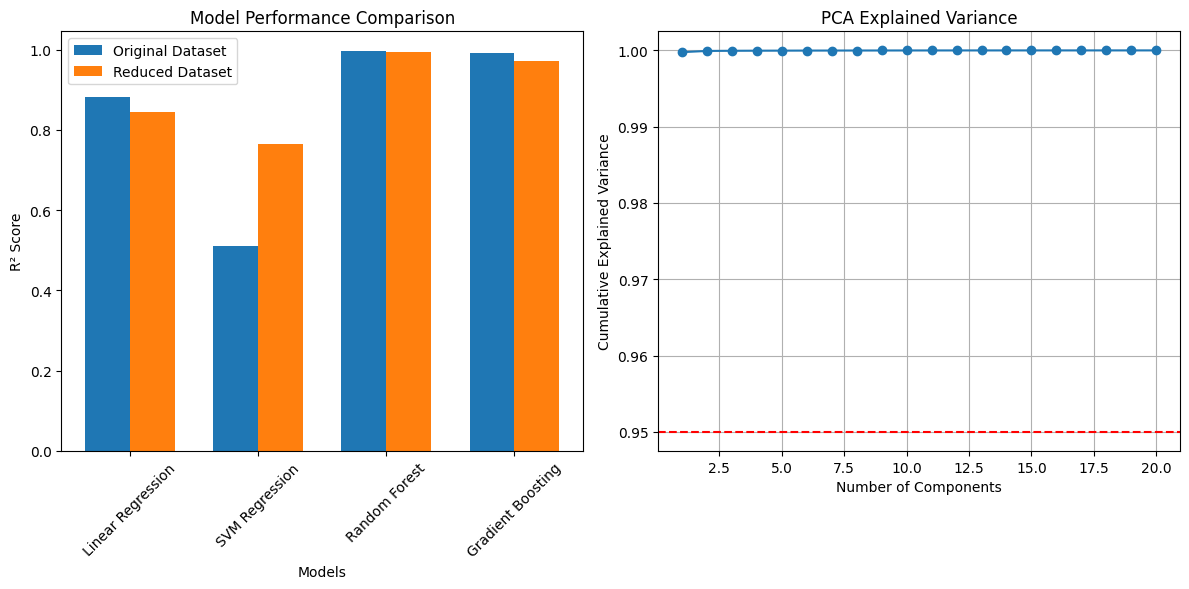


Performance Summary:
                   Original Dataset R²  Reduced Dataset R²  R² Difference  \
Linear Regression             0.882584            0.845598      -0.036986   
SVM Regression                0.511465            0.765031       0.253567   
Random Forest                 0.995971            0.995218      -0.000753   
Gradient Boosting             0.992306            0.972255      -0.020051   

                   Original Training Time (s)  Reduced Training Time (s)  \
Linear Regression                    0.644948                   0.456647   
SVM Regression                     548.071340                4387.930583   
Random Forest                      729.952195                 455.721858   
Gradient Boosting                  399.620282                 252.442725   

                   Time Savings (%)  
Linear Regression         29.196231  
SVM Regression          -700.613034  
Random Forest             37.568260  
Gradient Boosting         36.829351  


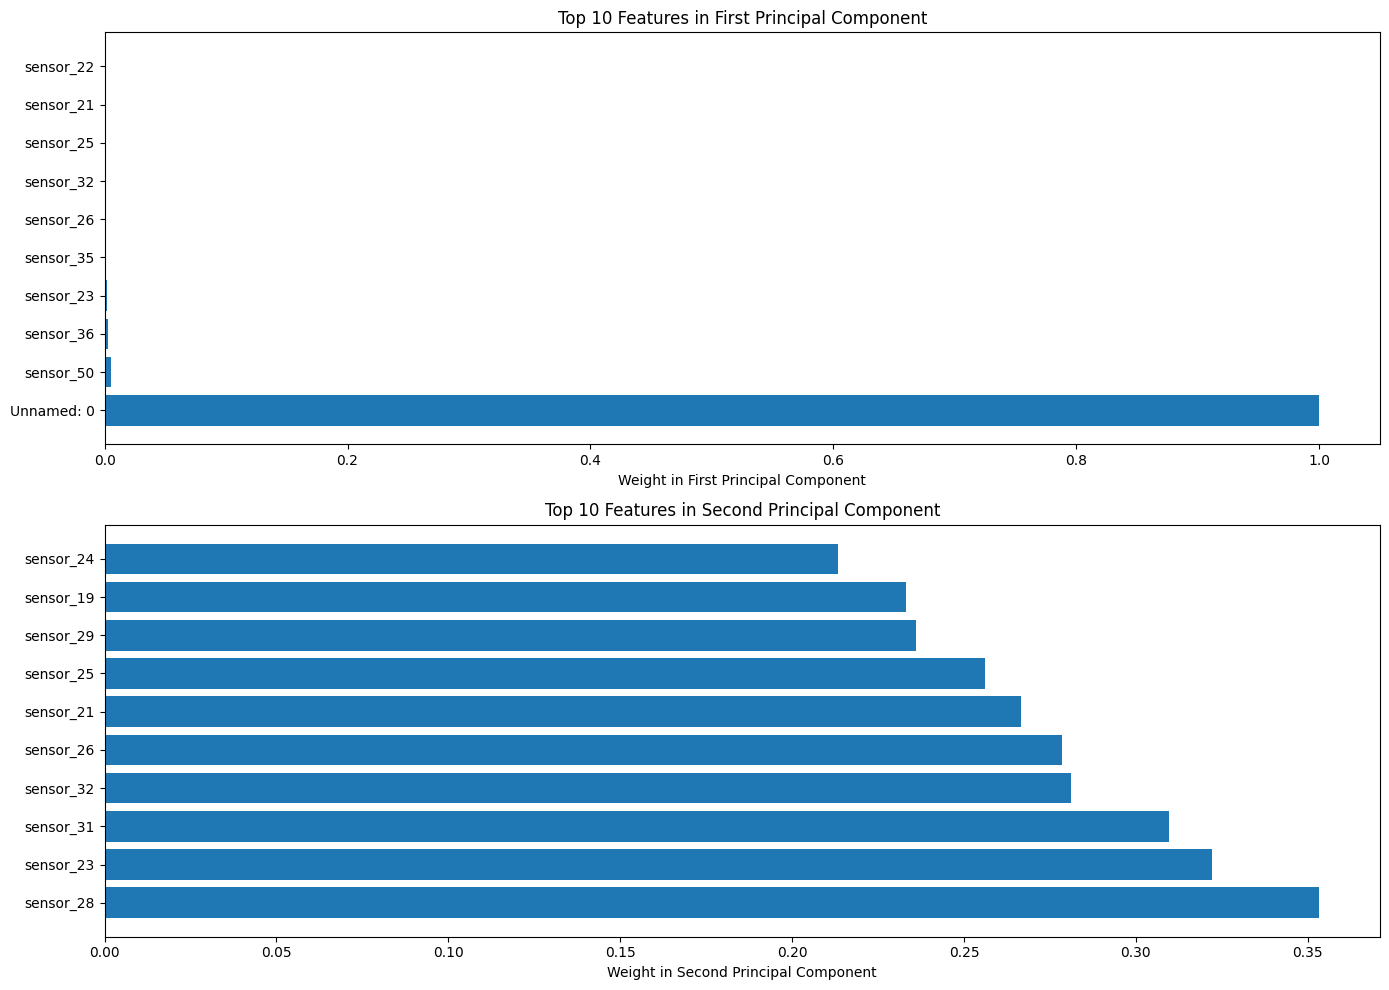

In [18]:
# Create visualization for the results
plt.figure(figsize=(12, 6))

# Plot model performance comparison
models_list = list(models.keys())
original_r2 = [original_results[name]['R2'] for name in models_list]
reduced_r2 = [reduced_results[name]['R2'] for name in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x - width/2, original_r2, width, label='Original Dataset')
plt.bar(x + width/2, reduced_r2, width, label='Reduced Dataset')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.tight_layout()

# Plot PCA explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()

plt.savefig('pca_results.png')
plt.show()

# Summary table
performance_summary = pd.DataFrame({
    'Original Dataset R²': original_r2,
    'Reduced Dataset R²': reduced_r2,
    'R² Difference': np.array(reduced_r2) - np.array(original_r2),
    'Original Training Time (s)': [original_times[name] for name in models_list],
    'Reduced Training Time (s)': [reduced_times[name] for name in models_list],
    'Time Savings (%)': [(1 - reduced_times[name]/original_times[name]) * 100 for name in models_list]
}, index=models_list)

print("\nPerformance Summary:")
print(performance_summary)

# Save results to CSV
performance_summary.to_csv('pca_performance_summary.csv')

# Feature importance visualization (using the original feature names)
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'sensor_{i:02d}' for i in range(X_imputed.shape[1])]

plt.figure(figsize=(14, 10))
pca_components = pd.DataFrame(
    pca.components_,
    columns=feature_names
)

# Get top features from first 2 principal components
plt.subplot(2, 1, 1)
top_features_pc1 = pca_components.iloc[0].abs().sort_values(ascending=False).head(10).index
plt.barh(range(len(top_features_pc1)), pca_components.iloc[0][top_features_pc1])
plt.yticks(range(len(top_features_pc1)), top_features_pc1)
plt.xlabel('Weight in First Principal Component')
plt.title('Top 10 Features in First Principal Component')

if len(pca_components) > 1:
    plt.subplot(2, 1, 2)
    top_features_pc2 = pca_components.iloc[1].abs().sort_values(ascending=False).head(10).index
    plt.barh(range(len(top_features_pc2)), pca_components.iloc[1][top_features_pc2])
    plt.yticks(range(len(top_features_pc2)), top_features_pc2)
    plt.xlabel('Weight in Second Principal Component')
    plt.title('Top 10 Features in Second Principal Component')

plt.tight_layout()
plt.savefig('pca_feature_importance.png')
plt.show()